In [ ]:
# import os
# from av2.datasets.sensor.av2_sensor_dataloader import  AV2SensorDataLoader
# from pathlib import Path
# from av2.structures.sweep import Sweep

# dataset_path = Path(os.path.join(os.path.expanduser("~"), 'buni', 'dataset','av2','train'))

# av2 = AV2SensorDataLoader(data_dir=dataset_path, labels_dir=dataset_path)

# scene_id = av2.get_log_ids()[0]
# frame_path = av2.get_ordered_log_lidar_fpaths(scene_id)[0]

# sweep = Sweep.from_feather(frame_path)

# points = sweep.xyz

# timetstamp = sweep.timestamp_ns
# import os
# import pandas as pd

# frame_path = av2.get_lidar_fpath(scene_id, timetstamp)

# lidar_frame_feather = pd.read_feather(frame_path)
# points =  lidar_frame_feather[['x', 'y', 'z','laser_number','intensity']].values

In [ ]:
# import open3d as o3d
# import matplotlib.pyplot as plt
# import numpy as np
# def viz_pd(points):
#     pcd = o3d.geometry.PointCloud()
#     pcd.points = o3d.utility.Vector3dVector(points)

#     # add coordinat axes to the point cloud
#     mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10, origin=[0, 0, 0])
#     o3d.visualization.draw_geometries([pcd, mesh_frame])

# def viz_points2d(points: np.ndarray):
#     # Assuming points is an nx3 numpy array
#     x = points[:, 0]
#     y = points[:, 1]
#     plt.figure(figsize=(10, 10))
#     plt.scatter(x, y, s=1)  # s is the marker size
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.title('Bird\'s Eye View (BEV) of Point Cloud')
#     plt.axis('equal')
#     plt.show()
    
# # viz_points2d(points)
# # viz_pd(points[:,:3])

In [ ]:
# from ray_dropper import RayDropper

# rd = RayDropper()
# dropped_points = rd.drop_rays(points)

ray-dropper => counter: 0, spherical_resolution: 600, beam_drop_ratio: 2 


In [12]:
# viz_points2d(dropped_points[:,:3])
# viz_pd(dropped_points[:,:3])

In [13]:
import os.path
import numpy as np
import time
import torch
from utils import plot_bev, get_points_in_a_rotated_box, plot_label_map, trasform_label2metric
from torch.utils.data import Dataset, DataLoader
from av2.datasets.sensor.av2_sensor_dataloader import  AV2SensorDataLoader
import pandas as pd
from pathlib import Path
from typing import List, Tuple
from ray_dropper import RayDropper
AV2_PATH = os.path.join(os.path.expanduser('~'), 'buni','dataset','av2')

class AV2(Dataset):

    geometry = {
        'L1': -40.0,
        'L2': 40.0,
        'W1': 0.0,
        'W2': 70.0,
        'H1': -2.5,
        'H2': 1.0,
        'input_shape': (800, 700, 36),
        'label_shape': (200, 175, 7)
    }

    target_mean = np.array([0.008, 0.001, 0.202, 0.2, 0.43, 1.368])
    target_std_dev = np.array([0.866, 0.5, 0.954, 0.668, 0.09, 0.111])


    def __init__(self,train=True):
        self.dataset_api = None
        self.train = train
        if train:
            train_path = Path(os.path.join(AV2_PATH, 'train'))
            self.av2_api = AV2SensorDataLoader(data_dir=train_path, labels_dir=train_path)
        else:
            test_path = Path(os.path.join(AV2_PATH, 'test'))
            self.av2_api = AV2SensorDataLoader(data_dir=test_path, labels_dir=test_path)
        
        self.scenes = self.av2_api.get_log_ids()
        self.global_to_scene_frame = []  # List mapping global index to (scene_id, frame_idx)
        self.total_frames = 0

    def __len__(self):
        return self.total_frames

    def __getitem__(self, item):
        scan = self.load_velo_scan(item)
        rd = RayDropper()
        scan = rd.drop_rays(scan)
        scan = self.lidar_preprocess(scan)
        scan = torch.from_numpy(scan)
        
        label_map, _ = self.get_label(item)
        self.reg_target_transform(label_map)
        label_map = torch.from_numpy(label_map)
        
        scan = scan.permute(2, 0, 1)
        label_map = label_map.permute(2, 0, 1)
        return scan, label_map, item


    def reg_target_transform(self, label_map: np.ndarray):
        '''
        Inputs are numpy arrays (not tensors!)
        :param label_map: [200 * 175 * 7] label tensor
        :return: normalized regression map for all non_zero classification locations
        '''
        cls_map = label_map[..., 0]
        reg_map = label_map[..., 1:]

        index = np.nonzero(cls_map)
        reg_map[index] = (reg_map[index] - self.target_mean)/self.target_std_dev
        
    def get_corners(self, bbox: List[float]) -> Tuple[np.ndarray, np.ndarray]:
        """
        return the 4 corners of the bounding box in the bird's eye view
        
        Args:
            bbox:  list of the bounding box parameters of shape (5)
        
        Returns:
            bev_corners: [4 * 2] numpy array of the 4 corners' (x, y)
            reg_target: [6] numpy array of the regression targets  
        """
        x, y, l, w, yaw = bbox
        
        bev_corners = np.zeros((4, 2), dtype=np.float32)
        # rear left
        bev_corners[0, 0] = x - l/2 * np.cos(yaw) - w/2 * np.sin(yaw)
        bev_corners[0, 1] = y - l/2 * np.sin(yaw) + w/2 * np.cos(yaw)

        # rear right
        bev_corners[1, 0] = x - l/2 * np.cos(yaw) + w/2 * np.sin(yaw)
        bev_corners[1, 1] = y - l/2 * np.sin(yaw) - w/2 * np.cos(yaw)

        # front right
        bev_corners[2, 0] = x + l/2 * np.cos(yaw) + w/2 * np.sin(yaw)
        bev_corners[2, 1] = y + l/2 * np.sin(yaw) - w/2 * np.cos(yaw)

        # front left
        bev_corners[3, 0] = x + l/2 * np.cos(yaw) - w/2 * np.sin(yaw)
        bev_corners[3, 1] = y + l/2 * np.sin(yaw) + w/2 * np.cos(yaw)

        reg_target = [np.cos(yaw), np.sin(yaw), x, y, w, l]

        return bev_corners, reg_target


    def update_label_map(self, map: np.ndarray, bev_corners: np.ndarray, reg_target: np.ndarray):
        """
        Args:
            map: [200 * 175 * 7] numpy array
            bev_corners: [4 * 2] numpy array of the 4 corners' (x, y)
            reg_target: [6] numpy array of the regression targets
        
        Returns:
            None
        """
        label_corners = (bev_corners / 4 ) / 0.1
        label_corners[:, 1] += self.geometry['label_shape'][0] / 2

        points = get_points_in_a_rotated_box(label_corners, self.geometry['label_shape'])

        for p in points:
            label_x = p[0]
            label_y = p[1]
            metric_x, metric_y = trasform_label2metric(np.array(p))
            actual_reg_target = np.copy(reg_target)
            actual_reg_target[2] = reg_target[2] - metric_x
            actual_reg_target[3] = reg_target[3] - metric_y
            actual_reg_target[4] = np.log(reg_target[4])
            actual_reg_target[5] = np.log(reg_target[5])

            map[label_y, label_x, 0] = 1.0
            map[label_y, label_x, 1:7] = actual_reg_target


    def get_label(self, index):
        '''
        :param i: the ith velodyne scan in the train/val set
        :return: label map: <--- This is the learning target
                a tensor of shape 800 * 700 * 7 representing the expected output


                label_list: <--- Intended for evaluation metrics & visualization
                a list of length n; n =  number of cars + (truck+van+tram+dontcare) in the frame
                each entry is another list, where the first element of this list indicates if the object
                is a car or one of the 'dontcare' (truck,van,etc) object

        '''
        if self.train:
            label_path = os.path.join(os.path.expanduser('~'),'buni', 'output-data','av2','bbox-estimation')
        else:
            raise NotImplementedError("Labels for test set are not available")
        log_id, frame_id = self.global_to_scene_frame[index]
        print(f"get_label() called => log_id is {log_id} and frame_id is {frame_id}")
        label_map = np.zeros(self.geometry['label_shape'], dtype=np.float32)
        label_list = []
      
        labels_df = pd.read_feather(os.path.join(label_path, log_id, str(frame_id) + '.feather'))
        
        for index, row in labels_df.iterrows():
            #convert row into a list
            row = row.tolist()
            corners, reg_target = self.get_corners(row)
            self.update_label_map(label_map, corners, reg_target)
            label_list.append(corners)
        return label_map, label_list

    def get_rand_velo(self):
        import random
        rand_v = random.choice(self.velo)
        print("A Velodyne Scan has shape ", rand_v.shape)
        return random.choice(self.velo)

    def load_velo_scan(self, item: int) -> np.ndarray:
        """
        Helper method to get a lidar frame
        
        Args:
            item: The index of the frame to get
        
        Returns:
            A numpy array of shape (N,5)
            Colmuns => x, y, z, laser_number, intensity
        """
        log_id, frame_id = self.global_to_scene_frame[item]
        
        frame_path = self.av2_api.get_lidar_fpath(log_id,frame_id)
        lidar_frame_feather = pd.read_feather(frame_path)
        scan =  lidar_frame_feather[['x', 'y', 'z','laser_number','intensity']].values
        
        return scan

    
    def load_velo(self):
        """Precompute mapping to fill the global_to_scene_frame list"""
        for scene_id in self.scenes:
            frames = self.av2_api.get_ordered_log_lidar_timestamps(scene_id)
            num_frames = len(frames)
            for frame_idx in range(num_frames):
                self.global_to_scene_frame.append((scene_id, frames[frame_idx]))
        self.global_to_scene_frame = self.global_to_scene_frame[::10] # select every 10th sequence to speed up training in av2
        self.total_frames = len(self.global_to_scene_frame)  
        print(f"Total frames: {self.total_frames}")
        print("Done pre-computing the mapping")

    def point_in_roi(self, point):
        if (point[0] - self.geometry['W1']) < 0.01 or (self.geometry['W2'] - point[0]) < 0.01:
            return False
        if (point[1] - self.geometry['L1']) < 0.01 or (self.geometry['L2'] - point[1]) < 0.01:
            return False
        if (point[2] - self.geometry['H1']) < 0.01 or (self.geometry['H2'] - point[2]) < 0.01:
            return False
        return True

    def passthrough(self, velo):
        """
        Helper method to filter out points that are not in the region of interest
        
        Args:
            velo: A numpy array of shape (n, 4) containing the lidar scan
            Columns => x, y, z, intensity
        
        Returns:
            A numpy array of shape (n, 4) containing the lidar scan
        """
        geom = self.geometry
        q = (geom['W1'] < velo[:, 0]) * (velo[:, 0] < geom['W2']) * \
            (geom['L1'] < velo[:, 1]) * (velo[:, 1] < geom['L2']) * \
            (geom['H1'] < velo[:, 2]) * (velo[:, 2] < geom['H2'])
        indices = np.where(q)[0]
        return velo[indices, :]

    def lidar_preprocess(self, scan: np.ndarray) -> np.ndarray:
        """
        Voxelizes the lidar scan
        
        Args:
            scan: A numpy array of shape (n, 4) containing the lidar scan
            Columns => x, y, z, intensity
        
        Returns:
            A numpy array of shape (36, 800, 700) containing the voxelized lidar scan
        """
        velo_processed = np.zeros(self.geometry['input_shape'], dtype=np.float32)
        intensity_map_count = np.zeros((velo_processed.shape[0], velo_processed.shape[1]))
        velo = self.passthrough(scan)
        for i in range(velo.shape[0]):
            x = int((velo[i, 1]-self.geometry['L1']) / 0.1)
            y = int((velo[i, 0]-self.geometry['W1']) / 0.1)
            z = int((velo[i, 2]-self.geometry['H1']) / 0.1)
            velo_processed[x, y, z] = 1
            velo_processed[x, y, -1] += velo[i, 3]
            intensity_map_count[x, y] += 1
        velo_processed[:, :, -1] = np.divide(velo_processed[:, :, -1],  intensity_map_count,
                                             where=intensity_map_count != 0)
        return velo_processed
    


In [14]:
def get_data_loader(batch_size, use_npy, geometry=None):
    train_dataset = AV2(train=True)
    if geometry is not None:
        train_dataset.geometry = geometry
    train_dataset.load_velo()
    train_data_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, num_workers=0)
    
    val_dataset = AV2(train=False)
    if geometry is not None:
        val_dataset.geometry = geometry
    val_dataset.load_velo()
    val_data_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size * 4, num_workers=0)
    print(f"Total frames in train dataset: {len(train_dataset)}")
    print(f"Total frames in validation dataset: {len(val_dataset)}")
    print("------------------------------------------------------------------")
    return train_data_loader, val_data_loader


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import numpy as np

def get_bev2(velo_array, label_list=None, scores=None):
    '''
    Generate a Bird's Eye View (BEV) intensity image from the LiDAR point cloud.

    :param velo_array: A 3D numpy array of shape (H, W, D) where H and W are spatial dimensions,
                       and D is the number of features per grid cell.
    :param label_list: (Optional) A list of numpy arrays of shape [4, 2], representing bounding box corners.
    :param scores: (Optional) List of scores associated with each bounding box.
    :return: A 2D numpy array representing the BEV intensity image.
    '''
    map_height = velo_array.shape[0]

    # Compute the maximum value across all channels except the last one
    val = (1 - velo_array[::-1, :, :-1].max(axis=2)) * 255
    val = val.astype(np.uint8)

    # Create a grayscale intensity image
    intensity_image = val

    return intensity_image


import matplotlib.pyplot as plt
import numpy as np
from typing import List
def plot_bev2(velo_array: np.ndarray, label_list:List[np.ndarray] =None, scores=None):
    '''
    Plot a Bird's Eye View (BEV) Lidar and bounding boxes using Matplotlib.
    The heading of the vehicle is marked as a red line
    (which connects front right and front left corner).

    :param velo_array: A 3D numpy array of LiDAR data of shape (800,700,36)
    :param label_list: A list of numpy arrays of shape [4, 2], which correspond to the 4 corners' (x, y).
                       The corners should be in the following sequence:
                       rear left, rear right, front right, and front left.
    :param scores: Optional list of scores for the bounding boxes.
    :return: None
    '''
    print("LOG: executing plot_bev2")
    
    # Generate the BEV intensity image
    intensity = get_bev2(velo_array, label_list, scores)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(intensity, cmap='gray')
    plt.axis('off')  # Hide axes for better visualization
    
    # Optionally, plot the bounding boxes
    if label_list is not None:
        for label in label_list:
            corners = label / 0.1  # Scale to match pixel coordinates
            map_height = intensity.shape[0]
            corners[:, 1] += int(map_height // 2)
            corners[:, 1] = map_height - corners[:, 1]
            corners = corners.reshape(-1, 2)
            # Close the loop by appending the first point at the end
            corners = np.vstack([corners, corners[0]])
            plt.plot(corners[:, 0], corners[:, 1], color='lime', linewidth=2)
            # Draw the heading line (front right to front left corner)
            heading = corners[2:4]
            plt.plot(heading[:, 0], heading[:, 1], color='red', linewidth=2)
    
    plt.show()
    print("LOG: plot_bev2 executed")

In [26]:
def test():
    # npy average time 0.31s
    # c++ average time 0.08s 4 workers
    batch_size = 3
    train_data_loader, val_data_loader = get_data_loader(batch_size, False)
    times = []
    tic = time.time()
    for i, (input, label_map, item) in enumerate(train_data_loader):
        toc = time.time()
        print(toc - tic)
        times.append(toc-tic)
        tic = time.time()
        print("Entry", i)
        print("Input shape:", input.shape)
        print("Label Map shape", label_map.shape)
        if i == 5:
            break
    print("average preprocess time per image", np.mean(times)/batch_size)    

    print("Finish testing train dataloader")
    
import matplotlib
%matplotlib inline
from ray_dropper import RayDropper
import matplotlib.pyplot as plt
def test0():
    k = AV2()

    id = 0
    k.load_velo()
    tstart = time.time()
    scan = k.load_velo_scan(id)
    rd = RayDropper()
    scan = rd.drop_rays(scan)
    print(scan.shape)
    processed_v = k.lidar_preprocess(scan)
    label_map, label_list = k.get_label(id)
    print('time taken: %gs' %(time.time()-tstart))
    plot_bev2(processed_v, label_list)
    plot_label_map(label_map[:, :, 6])
    plot_label_map(label_map[:, :, 0])


Total frames: 52
Done pre-computing the mapping
ray-dropper => counter: 0, spherical_resolution: 1200, beam_drop_ratio: 2 
(11634, 5)
get_label() called => log_id is ff52c01e-3d7b-32b1-b6a1-bcff3459ccdd and frame_id is 315968335160099000
time taken: 0.0720396s
LOG: executing plot_bev2


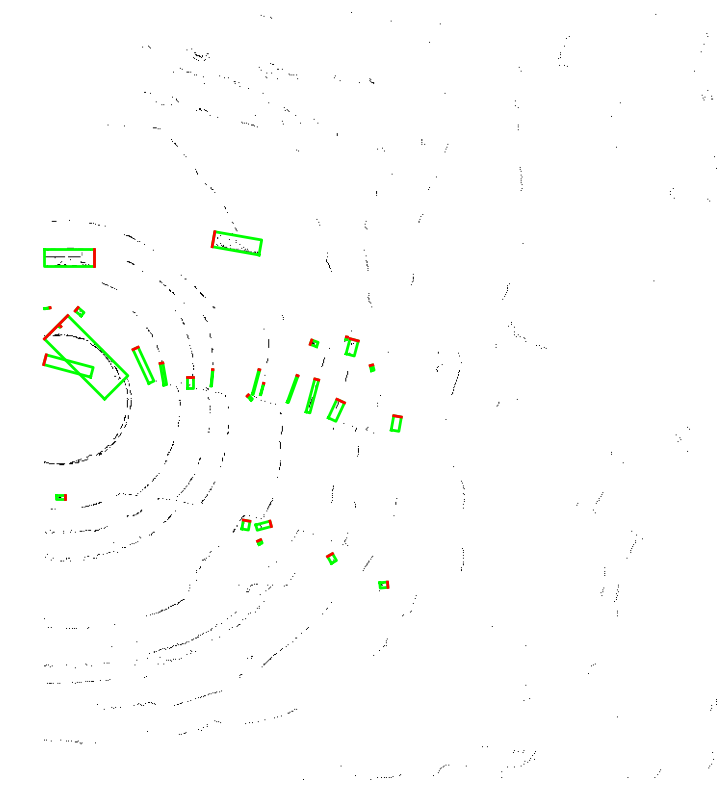

LOG: plot_bev2 executed
LOG: executing plot_label_map


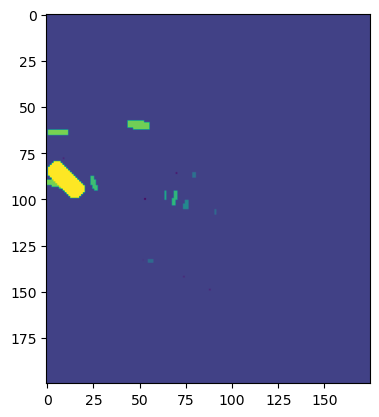

LOG: plot_label_map executed
LOG: executing plot_label_map


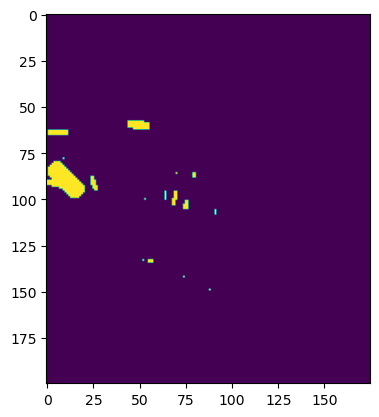

LOG: plot_label_map executed


In [31]:
test0()